## Lab 8 task: 
### "Denoising Autoencoder"


1. You should create convolutional denoising autoencoder, which will remove noise from the images from CIFAR10 dataset.
2. Develop a function that takes as input noised image from CIFAR10 dataset and returns reconstructed one.


In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
import numpy as np
import warnings
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test  = np.reshape(x_test,  (len(x_test),  32, 32, 3))

In [3]:
def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
def noised_image(image,power_of_noise):
    noised_image = image + 3 * image.std() * np.random.random(image.shape)*power_of_noise
    return noised_image

In [5]:
def create_conv_ae():
    # Dimension of coded image:
    encoding_dim = 150

    input_img = Input(shape = (32, 32, 3))
    
    # encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2),padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2),padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
        
    return encoded, decoded, autoencoder

In [6]:
encoder, decoder, autoencoder = create_conv_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
__________

In [8]:
noise_train, noise_test = [], []

for image in x_train:
    noise_train.append(noised_image(image, 0.4))
noise_train = [noise_train] 

for image in x_test:
    noise_test.append(noised_image(image, 0.4))
noise_test = [noise_test]

In [9]:
print(np.shape(x_test))

(10000, 32, 32, 3)


In [10]:
autoencoder.fit(noise_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 176s 4ms/step - loss: 0.5821 - val_loss: 0.5687
Epoch 2/5
50000/50000 [==============================] - 199s 4ms/step - loss: 0.5662 - val_loss: 0.5665
Epoch 3/5
50000/50000 [==============================] - 214s 4ms/step - loss: 0.5639 - val_loss: 0.5635
Epoch 4/5
50000/50000 [==============================] - 135s 3ms/step - loss: 0.5624 - val_loss: 0.5628
Epoch 5/5
50000/50000 [==============================] - 135s 3ms/step - loss: 0.5617 - val_loss: 0.5617


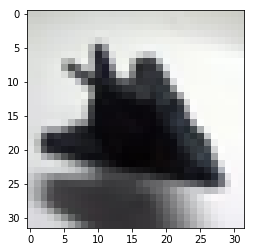

In [11]:
plt.imshow(x_train[29])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


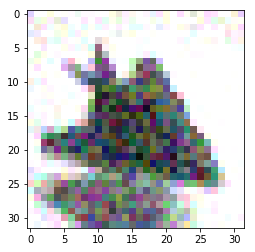

In [12]:
test_noised_image = noised_image(x_train[29],0.4)
plt.imshow(test_noised_image)
plt.show()

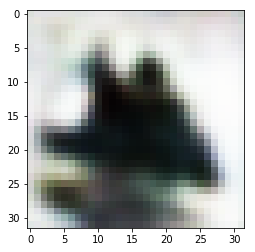

In [13]:
test_noised_image = np.reshape(test_noised_image, (1, 32, 32, 3))
predicted_noised_image = autoencoder.predict(test_noised_image)
plt.imshow(predicted_noised_image[0])
plt.show()